<a href="https://colab.research.google.com/github/palakagl/CapstoneProject/blob/main/Insurance_Linear_Regression_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear regression is a supervised learining algorithm used when target / dependent variable continues real number. It establishes relationship between dependent variable  y  and one or more independent variable  x  using best fit line. It work on the principle of ordinary least square  (OLS)  / Mean square errror  (MSE) . In statistics ols is method to estimated unkown parameter of linear regression function, it's goal is to minimize sum of square difference between observed dependent variable in the given data set and those predicted by linear regression fuction.


In [ ]:
!pip install catboost
!pip install shap
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 31.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.8 MB/s 


In [ ]:
# Import library
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
import io
import statsmodels.api as sm
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import catboost as cb
import shap
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['insurance.csv']))
print('\nNumber of rows and columns in the data set: ',df.shape)
print('')

#Lets look into top few rows and columns in the dataset
df.head()


Number of rows and columns in the data set:  (1338, 7)



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


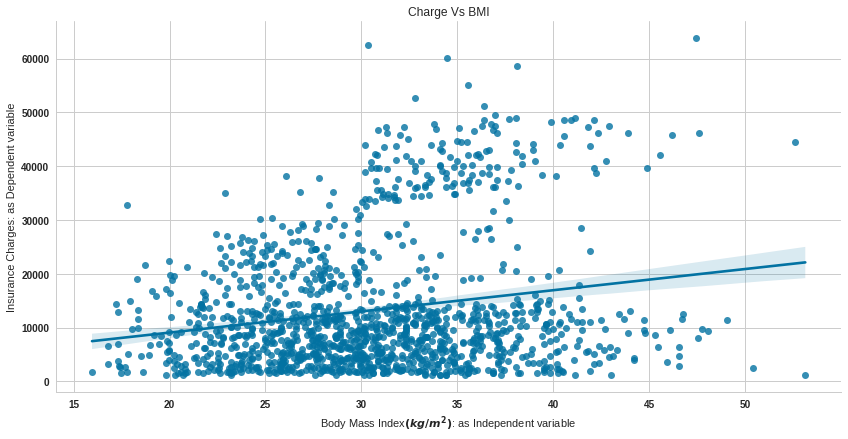

In [ ]:
sns.lmplot(x='bmi',y='charges',data=df,aspect=2,height=6)
plt.xlabel('Body Mass Index$(kg/m^2)$: as Independent variable')
plt.ylabel('Insurance Charges: as Dependent variable')
plt.title('Charge Vs BMI');

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Apparently, we have no missing values on our data, so we’re good to go! The average, medical cost is USD 13,270 with a median value of USD 9382. The respondents’ gender and region of origin is evenly distributed, having age ranging from 18 to 64 years old. Non-smokers outnumber smokers 4 to 1.

the hypothesis function looks like

hθ(xi)=θ0+θ1age+θ2sex+θ3bmi+θ4children+θ5smoker+θ6region

<Figure size 864x288 with 0 Axes>

Text(0.5, 1.0, 'Missing value in the dataset')

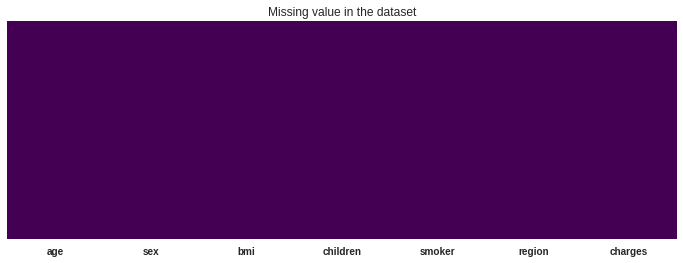

In [ ]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset')

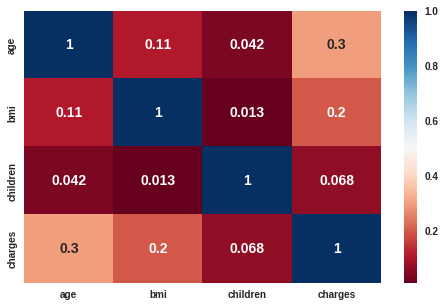

In [ ]:
corr = df.corr()
sns.heatmap(corr, cmap = 'RdBu', annot= True)

We can see that age has the highest correlation with charges amongst our numeric variables. Another observation we can make from this plot is that none of our numeric values is highly correlated with each other, so multicollinearity wouldn’t be a problem

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


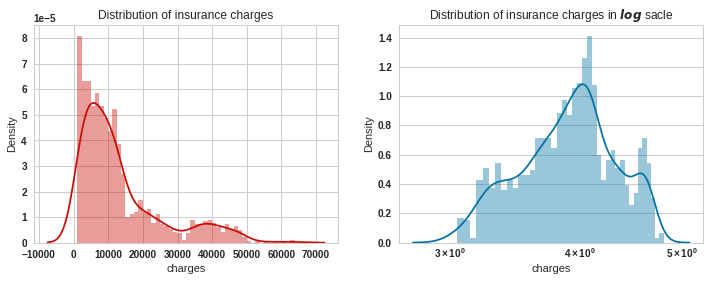

In [ ]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['charges'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance charges')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['charges']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance charges in $log$ sacle')
ax.set_xscale('log');

Text(0.5, 1.0, 'Violin plot of Charges vs sex')

Text(0.5, 1.0, 'Violin plot of Charges vs smoker')

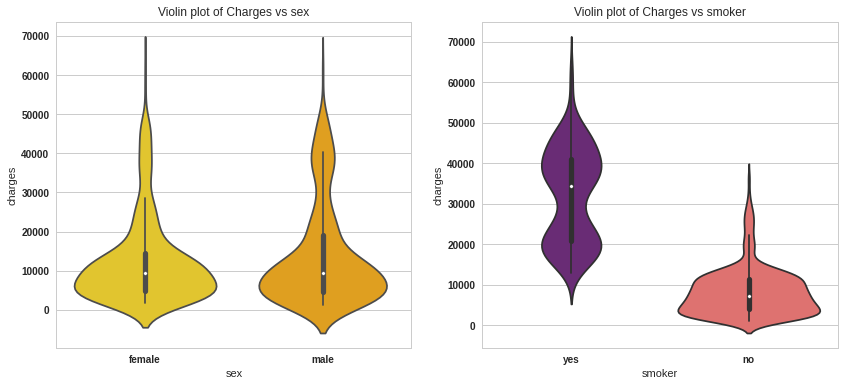

In [ ]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=df,palette='Wistia',ax=ax)
ax.set_title('Violin plot of Charges vs sex')

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=df,palette='magma',ax=ax)
ax.set_title('Violin plot of Charges vs smoker')

we can see that there is no obvious pattern between gender and premium charged. On the other hand, the same cannot be said with smoking status. It can be clearly observed that smokers have a higher premium charges.

<Figure size 1008x432 with 0 Axes>

Text(0.5, 1.0, 'Box plot of charges vs children')

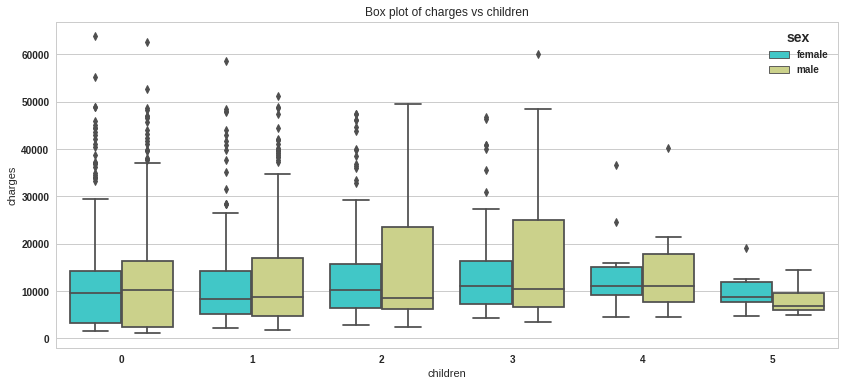

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children', y='charges',hue='sex',data=df,palette='rainbow')
plt.title('Box plot of charges vs children')

<Figure size 1008x432 with 0 Axes>

Text(0.5, 1.0, 'Violin plot of charges vs children')

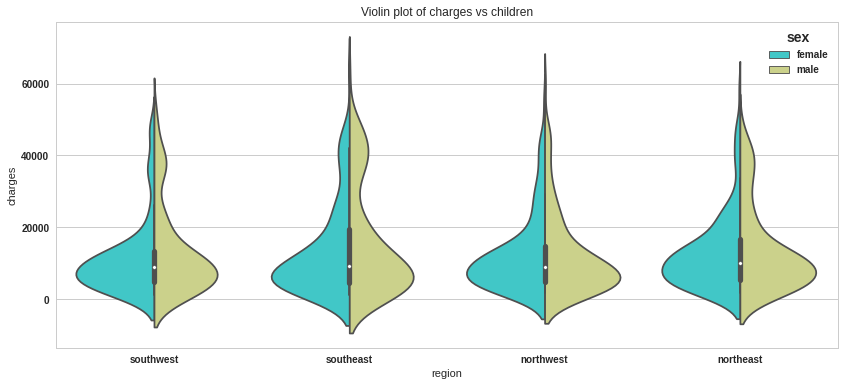

In [ ]:
plt.figure(figsize=(14,6))
sns.violinplot(x='region', y='charges',hue='sex',data=df,palette='rainbow',split=True)
plt.title('Violin plot of charges vs children')

Based from the plot above, we can see that region of origin doesn’t have much impact with the amount of premimum charged

Text(0.5, 1.0, 'Scatter plot of Charges vs age')

Text(0.5, 1.0, 'Scatter plot of Charges vs bmi')

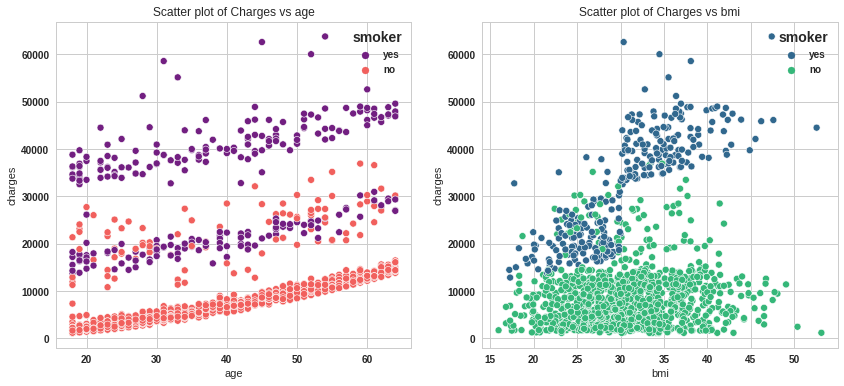

In [ ]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df,palette='magma',hue='smoker',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df,palette='viridis',hue='smoker')
ax.set_title('Scatter plot of Charges vs bmi')
plt.savefig('sc.png')

In [ ]:
'''
categorical_columns = ['sex','children', 'smoker', 'region']
df_encode = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',
                           columns = categorical_columns, drop_first =False, dtype='int8')
df_encode.head(10)
'''

"\ncategorical_columns = ['sex','children', 'smoker', 'region']\ndf_encode = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',\n                           columns = categorical_columns, drop_first =False, dtype='int8')\ndf_encode.head(10)\n"

In [ ]:
encoder = TargetEncoder()
df_encode = df.copy()

# categorical_columns = ['sex','children', 'smoker', 'region']
df_encode['sex_encoded'] = encoder.fit_transform(df_encode['sex'], df_encode['charges'])
df_encode = df_encode.drop('sex',axis=1)
df_encode['children_encoded'] = encoder.fit_transform(df_encode['children'], df_encode['charges'])
df_encode = df_encode.drop('children',axis=1)
df_encode['smoker_encoded'] = encoder.fit_transform(df_encode['smoker'], df_encode['charges'])
df_encode = df_encode.drop('smoker',axis=1)
df_encode['region_encoded'] = encoder.fit_transform(df_encode['region'], df_encode['charges'])
df_encode = df_encode.drop('region',axis=1)

df_encode.head(10)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


,age,bmi,charges,sex_encoded,children_encoded,smoker_encoded,region_encoded
0,19,27.900,16884.92400,12569.578844,0,32050.231832,12346.937377
1,18,33.770,1725.55230,13956.751178,1,8434.268298,14735.411438
2,28,33.000,4449.46200,13956.751178,3,8434.268298,14735.411438
3,33,22.705,21984.47061,13956.751178,0,8434.268298,12417.575374
4,32,28.880,3866.85520,13956.751178,0,8434.268298,12417.575374
5,31,25.740,3756.62160,12569.578844,0,8434.268298,14735.411438
6,46,33.440,8240.58960,12569.578844,1,8434.268298,14735.411438
7,37,27.740,7281.50560,12569.578844,3,8434.268298,12417.575374
8,37,29.830,6406.41070,13956.751178,2,8434.268298,13406.384516
9,60,25.840,28923.13692,12569.578844,0,8434.268298,12417.575374


In [ ]:
print('Columns in original data frame:\n',df.columns.values)
print('\nNumber of rows and columns in the dataset:',df.shape)
print('\nColumns in data frame after encoding dummy variable:\n',df_encode.columns.values)
print('\nNumber of rows and columns in the dataset:',df_encode.shape)

Columns in original data frame:
 ['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']

Number of rows and columns in the dataset: (1338, 7)

Columns in data frame after encoding dummy variable:
 ['age' 'bmi' 'charges' 'sex_encoded' 'children_encoded' 'smoker_encoded'
 'region_encoded']

Number of rows and columns in the dataset: (1338, 7)


In [ ]:
## Log transform
df_encode['charges'] = np.log(df_encode['charges'])

In [ ]:
X = df_encode.drop('charges',axis=1) # Independet variable
y = df_encode['charges'] # Dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

In [ ]:
X_train.head(5)
y_train.head(5)
X_test.head(5)
y_test.head(5)

,age,bmi,sex_encoded,children_encoded,smoker_encoded,region_encoded
923,34,35.815,13956.751178,0,8434.268298,12417.575374
1121,46,38.170,13956.751178,2,8434.268298,14735.411438
713,20,40.470,13956.751178,0,8434.268298,13406.384516
552,62,21.400,13956.751178,0,8434.268298,12346.937377
738,23,31.730,13956.751178,3,32050.231832,13406.384516


923      8.371106
1121     9.029677
713      7.593099
552      9.469401
738     10.496513
Name: charges, dtype: float64

,age,bmi,sex_encoded,children_encoded,smoker_encoded,region_encoded
918,61,28.200,12569.578844,0,8434.268298,12346.937377
755,31,27.645,13956.751178,2,8434.268298,13406.384516
207,35,27.740,13956.751178,2,32050.231832,13406.384516
520,50,27.360,12569.578844,0,8434.268298,13406.384516
695,26,40.185,12569.578844,0,8434.268298,12417.575374


918     9.475924
755     8.523428
207     9.951520
520    10.152555
695     8.071295
Name: charges, dtype: float64

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
# print the intercept
print(model.intercept_)

7.35300979904949


In [ ]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
age,0.033196
bmi,0.012034
sex_encoded,-0.000053
children_encoded,0.100461
smoker_encoded,0.000066
region_encoded,-0.000015


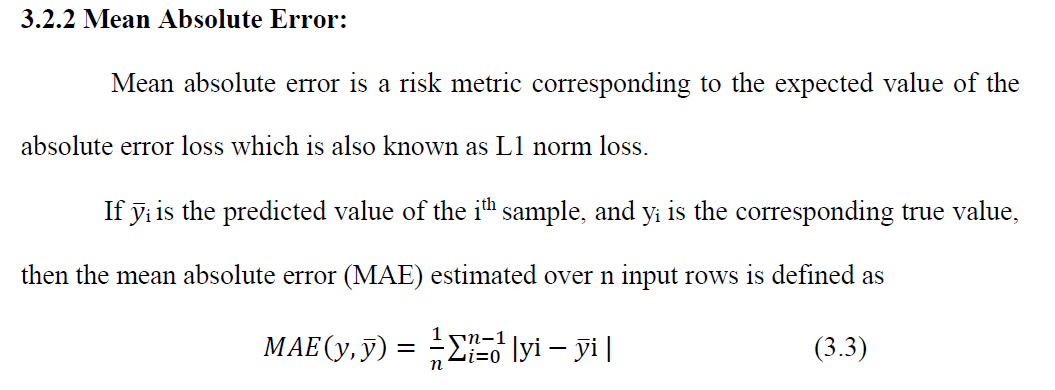

In [ ]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
evs = explained_variance_score(y_test, predictions)
msa = mean_absolute_percentage_error(y_test, predictions)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.7734
Explained Variance Score: 0.7735
Mean Square Error: 0.1925
Mean Absolute Percentage Error: 0.031647987256216356


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


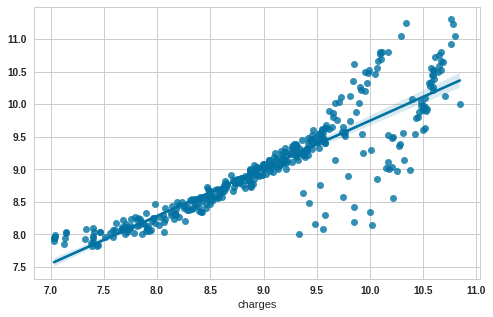

In [ ]:
sns.regplot(y_test,predictions)

In [ ]:
x_train_new = sm.add_constant(X_train)
x_test_new = sm.add_constant(X_test)

#random.seed(434)
model_ols = sm.OLS(y_train,x_train_new)
model_ols = model_ols.fit()
print ("\n \n",model_ols.summary())


 
                             OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     486.4
Date:                Sat, 23 Jul 2022   Prob (F-statistic):          1.31e-282
Time:                        23:14:32   Log-Likelihood:                -581.33
No. Observations:                 936   AIC:                             1177.
Df Residuals:                     929   BIC:                             1211.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.3530      0.3

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
y_pred_new = model_ols.predict(x_test_new)
mse = mean_squared_error(y_test, y_pred_new)
evs = explained_variance_score(y_test, y_pred_new)
r2 = r2_score(y_test, y_pred_new)
msa = mean_absolute_percentage_error(y_test, y_pred_new)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.7734
Explained Variance Score: 0.7735
Mean Square Error: 0.1925
Mean Absolute Percentage Error: 0.03164798725621881


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


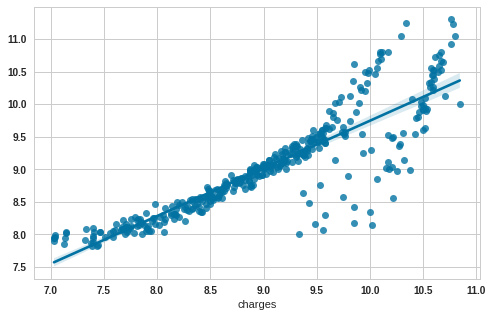

In [ ]:
sns.regplot(y_test,y_pred_new)

In [ ]:
print ("\nVariance Inflation Factor")
cnames = X_train.columns
for i in np.arange(0,len(cnames)):
    xvars = list(cnames)
    yvar = xvars.pop(i)
    mod = sm.OLS(X_train[yvar],sm.add_constant(x_train_new[xvars]))
    res = mod.fit()
    vif = 1/(1-res.rsquared)
    print (yvar,round(vif,3))


Variance Inflation Factor
age 1.017
bmi 1.072
sex_encoded 1.008
children_encoded 1.004
smoker_encoded 1.016
region_encoded 1.071


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


## Decision Tree regression model

In [ ]:
# Decision Tree regression model
regr_dt_1 = DecisionTreeRegressor(max_depth=3)
regr_dt_2 = DecisionTreeRegressor(max_depth=4)

In [ ]:
regr_dt_1 = regr_dt_1.fit(X_train, y_train)
regr_dt_2 = regr_dt_2.fit(X_train, y_train)

In [ ]:
# Predict
y_dt_pred_1 = regr_dt_1.predict(X_test)
y_dt_pred_2 = regr_dt_2.predict(X_test)

In [ ]:
# Plot the results
mse = mean_squared_error(y_test, y_dt_pred_1)
evs = explained_variance_score(y_test, y_dt_pred_1)
r2 = r2_score(y_test, y_dt_pred_1)
msa = mean_absolute_percentage_error(y_test, y_dt_pred_1)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.807
Explained Variance Score: 0.8072
Mean Square Error: 0.164
Mean Absolute Percentage Error: 0.02922866986590773



Prediction Error Plot


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


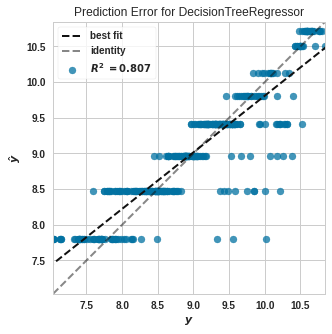

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa35e481950>,
                estimator=DecisionTreeRegressor(max_depth=3))


In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(regr_dt_1, X_train, y_train, X_test, y_test))

In [ ]:
mse = mean_squared_error(y_test, y_dt_pred_2)
evs = explained_variance_score(y_test, y_dt_pred_2)
r2 = r2_score(y_test, y_dt_pred_2)
msa = mean_absolute_percentage_error(y_test, y_dt_pred_2)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.8221
Explained Variance Score: 0.8228
Mean Square Error: 0.1512
Mean Absolute Percentage Error: 0.027306672837639195



Prediction Error Plot


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


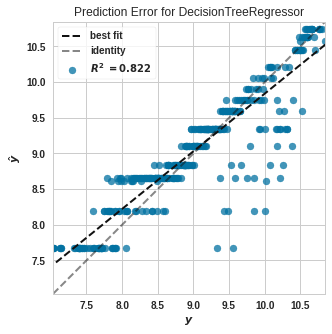

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa35e45aa10>,
                estimator=DecisionTreeRegressor(max_depth=4))


In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(regr_dt_2, X_train, y_train, X_test, y_test))

## Random Forest Regression Model

In [ ]:
## Define Grid 
grid = { 
    'n_estimators': [100,150,200,250,300],
    'max_depth' : [3,4,5,6],
    'random_state' : [11]
}

## Grid Search function
regr_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 10)
regr_rf.fit(X_train, y_train)
print(regr_rf.best_params_)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 150, 200, 250, 300],
                         'random_state': [11]})

{'max_depth': 4, 'n_estimators': 100, 'random_state': 11}


In [ ]:
# Predict
y_rf_pred = regr_rf.predict(X_test)

In [ ]:
# Plot the results
mse = mean_squared_error(y_test, y_rf_pred)
evs = explained_variance_score(y_test, y_rf_pred)
r2 = r2_score(y_test, y_rf_pred)
msa = mean_absolute_percentage_error(y_test, y_rf_pred)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.8355
Explained Variance Score: 0.8359
Mean Square Error: 0.1398
Mean Absolute Percentage Error: 0.024653667626144054



Prediction Error Plot


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


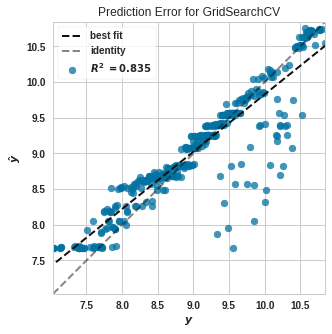

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa35e351750>,
                estimator=GridSearchCV(cv=10, estimator=RandomForestRegressor(),
                                       param_grid={'max_depth': [3, 4, 5, 6],
                                                   'n_estimators': [100, 150,
                                                                    200, 250,
                                                                    300],
                                                   'random_state': [11]}))


In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(regr_rf, X_train, y_train, X_test, y_test))

## XG Boost Regression Model

In [ ]:
## Define Grid 
grid = { 
    'n_estimators': [40, 50, 60, 70],
    'max_depth' : [2,3,4,5],
    'learning_rate' : [0.93,0.95, 0.97, 0.1],
    'random_state' : [11]
}

## Grid Search function
regr_xgb = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=grid, cv= 10)
regr_xgb.fit(X_train, y_train)
print(regr_xgb.best_params_)

[02:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=10, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.93, 0.95, 0.97, 0.1],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [40, 50, 60, 70],
                         'random_state': [11]})

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 70, 'random_state': 11}


In [ ]:
# Predict
y_xgb_pred = regr_xgb.predict(X_test)

In [ ]:
# Plot the results
mse = mean_squared_error(y_test, y_xgb_pred)
evs = explained_variance_score(y_test, y_xgb_pred)
r2 = r2_score(y_test, y_xgb_pred)
msa = mean_absolute_percentage_error(y_test, y_xgb_pred)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.852
Explained Variance Score: 0.8522
Mean Square Error: 0.1257
Mean Absolute Percentage Error: 0.021919792676532508



Prediction Error Plot


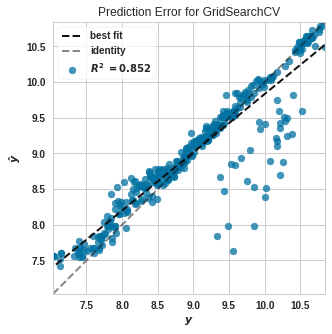

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf159ee850>,
                estimator=GridSearchCV(cv=10, estimator=XGBRegressor(),
                                       param_grid={'learning_rate': [0.93, 0.95,
                                                                     0.97,
                                                                     0.1],
                                                   'max_depth': [2, 3, 4, 5],
                                                   'n_estimators': [40, 50, 60,
                                                                    70],
                                                   'random_state': [11]}))


In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(regr_xgb, X_train, y_train, X_test, y_test))

In [ ]:
regr_xgb_bp = xgb.XGBRegressor(max_depth= 3,learning_rate=0.1, n_estimators=70, random_state=11)
regr_xgb_bp.fit(X_train, y_train)

[02:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=70, random_state=11)

In [ ]:
regr_xgb_bp_pred = regr_xgb_bp.predict(X_test)

In [ ]:
# Plot the results
mse = mean_squared_error(y_test, regr_xgb_bp_pred)
evs = explained_variance_score(y_test, regr_xgb_bp_pred)
r2 = r2_score(y_test, regr_xgb_bp_pred)
msa = mean_absolute_percentage_error(y_test, regr_xgb_bp_pred)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.852
Explained Variance Score: 0.8522
Mean Square Error: 0.1257
Mean Absolute Percentage Error: 0.021919792676532508


In [ ]:
explainer = shap.TreeExplainer(regr_xgb_bp)
shap_values = explainer.shap_values(X_test)

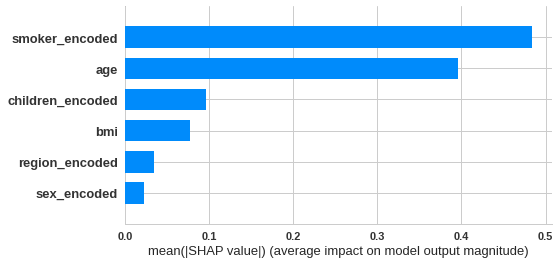

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

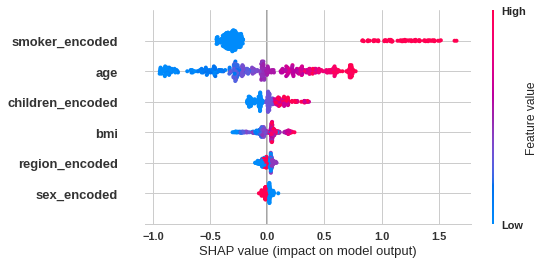

In [ ]:
shap.summary_plot(shap_values, X_test)

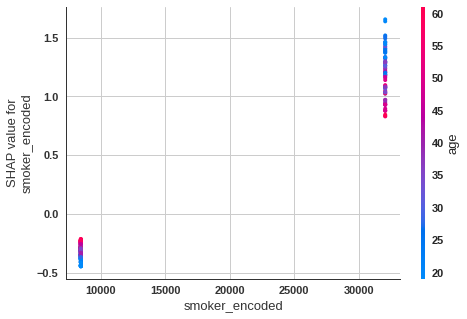

In [ ]:
shap.dependence_plot("smoker_encoded", shap_values, X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ["Sex", "children", "smoker", "region" ]
df_encode = df.copy()
oe_style = OneHotEncoder()

In [ ]:
df_encode.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
oe_results = oe_style.fit_transform(df_encode[["sex" ]])

#, "children", "smoker", "region"

In [ ]:
# limit to categorical data using df.select_dtypes()
Z = df_encode.select_dtypes(include=[object])
Z.head(3)

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast


In [ ]:
# import preprocessing from sklearn
from sklearn import preprocessing

In [ ]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
Z_2 = Z.apply(le.fit_transform)
Z_2.head()

,sex,smoker,region
0,0,1,3
1,1,0,2
2,1,0,2
3,1,0,1
4,1,0,1


In [ ]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
Z_2 = Z.apply(le.fit_transform)
Z_2.head()

,sex,smoker,region
0,0,1,3
1,1,0,2
2,1,0,2
3,1,0,1
4,1,0,1


In [ ]:
df_encode.drop(["age", "sex", "bmi"], axis = 1)

,children,smoker,region,charges
0,0,yes,southwest,16884.92400
1,1,no,southeast,1725.55230
2,3,no,southeast,4449.46200
3,0,no,northwest,21984.47061
4,0,no,northwest,3866.85520
...,...,...,...,...
1333,3,no,northwest,10600.54830
1334,0,no,northeast,2205.98080
1335,0,no,southeast,1629.83350
1336,0,no,southwest,2007.94500


In [ ]:
df_encode = df_encode.join(Z_2, columns=['sex', 'smoker', 'region'])

TypeError: ignored

In [ ]:
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

## Attempt using different model

In [ ]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
from sklearn.model_selection import train_test_split

# separate features and target

#df_copy = df.drop('charges', axis=1)
X = df.drop('charges', axis=1)
y = df['charges']
#X= df_copy 
    
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [ ]:
# import libraries
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# get the categorical and numeric column names
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
print(num_cols)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(cat_cols)
# pipeline for numerical columns
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
# pipeline for categorical columns
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='N/A'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

# combine both the pipelines
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# build the model
linreg = make_pipeline(
    cat_pipe, LinearRegression())

['age', 'bmi', 'children', 'charges']
['sex', 'smoker', 'region']


In [ ]:
X_train

,age,sex,bmi,children,smoker,region
332,61,female,31.160,0,no,northwest
355,46,male,27.600,0,no,southwest
138,54,female,31.900,3,no,southeast
381,55,male,30.685,0,yes,northeast
292,25,male,45.540,2,yes,southeast
...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast
1130,39,female,23.870,5,no,southeast
1294,58,male,25.175,0,no,northeast
860,37,female,47.600,2,yes,southwest


In [ ]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [ ]:
# train the model
linreg.fit(X_train, y_train)
# make predictions on the test set
y_pred = linreg.predict(X_test)

print(y_pred)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value='N/A',
                                                strategy='constant')),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False))])),
                ('linearregression', LinearRegression())])

[ 6.17200000e+03  1.07240000e+04  4.08760000e+04  1.04600000e+04
  2.61560000e+04  1.95000000e+04  1.22800000e+03 -2.86423499e+15
 -2.58000000e+03 -7.56000000e+02 -2.86423499e+15  1.03800000e+04
  3.11600000e+03 -2.86423499e+15 -2.86423499e+15  3.33560000e+04
 -2.86423499e+15  3.33880000e+04  1.15320000e+04  2.92280000e+04
 -2.86423499e+15 -2.86423499e+15  3.24400000e+03 -2.86423499e+15
  6.70000000e+03  2.16120000e+04 -2.86423499e+15  7.71600000e+03
  6.68400000e+03  2.36000000e+02  6.57200000e+03  7.96400000e+03
 -2.86423499e+15  3.07600000e+03 -2.86423499e+15 -2.86423499e+15
 -4.82000000e+03  5.90000000e+03  3.39200000e+04  3.15000000e+04
  1.93200000e+03  7.27600000e+03  1.20760000e+04  1.51480000e+04
  2.02040000e+04  1.22040000e+04  7.56400000e+03  2.98800000e+03
  2.88440000e+04  1.44440000e+04  1.83800000e+04 -2.86423499e+15
 -2.86423499e+15  3.00000000e+03  1.41560000e+04  1.51160000e+04
  7.40400000e+03  2.42040000e+04  1.50200000e+04  1.82200000e+04
 -2.86423499e+15 -2.86423

Save the model

In [ ]:
import pickle
#Save to file in the current working directory
pkl_filename = "linreg.pkl"
with open (pkl_filename, 'wb') as file:
  pickle.dump(linreg, file)
#Load from file
with open (pkl_filename, 'rb' ) as file:
  pickle_model = pickle.load(file)

Load the test data

In [ ]:

#Calculate the accuracy score and predict target values
uploaded = files.upload()
dftest = pd.read_csv(io.BytesIO(uploaded['insurance_test.csv']))

Saving insurance_test.csv to insurance_test (3).csv


In [ ]:
file = files.upload()

#file_bytes = file.values()
dftest = pd.read_csv(io.BytesIO(file['insurance_test.csv']))

NameError: ignored

In [ ]:
# make predictions on the test set
y_predtest = linreg.predict(dftest)

print(y_predtest)

[35596.]


In [ ]:
pip freeze

absl-py==1.2.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.1
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.7
catboost==1.0.6
category-encoders==2.5.0
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.5
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1

In [ ]:
import requests

resp = requests.post("https://index-ntmpyerkda-uc.a.run.app", files={'file': open('insurance_test.csv')})

print(resp.json())

{'error': "'FileStorage' object is not subscriptable"}


## CAT Boost Regression Model

In [ ]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
regr_cat = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 3, 4, 5, 6],
        'l2_leaf_reg': [0.2, 0.5, 1, 3],
        'random_state' : [42] 
        }
regr_cat.grid_search(grid, train_dataset)

Streaming output truncated to the last 5000 lines.
156:	learn: 0.3596410	test: 0.4823931	best: 0.4823931 (156)	total: 123ms	remaining: 33.8ms
157:	learn: 0.3588920	test: 0.4816534	best: 0.4816534 (157)	total: 124ms	remaining: 32.9ms
158:	learn: 0.3575663	test: 0.4806975	best: 0.4806975 (158)	total: 125ms	remaining: 32.2ms
159:	learn: 0.3563269	test: 0.4797971	best: 0.4797971 (159)	total: 125ms	remaining: 31.4ms
160:	learn: 0.3552171	test: 0.4792358	best: 0.4792358 (160)	total: 126ms	remaining: 30.6ms
161:	learn: 0.3541848	test: 0.4783179	best: 0.4783179 (161)	total: 127ms	remaining: 29.8ms
162:	learn: 0.3532540	test: 0.4778000	best: 0.4778000 (162)	total: 129ms	remaining: 29.2ms
163:	learn: 0.3523215	test: 0.4771840	best: 0.4771840 (163)	total: 129ms	remaining: 28.4ms
164:	learn: 0.3512982	test: 0.4762880	best: 0.4762880 (164)	total: 130ms	remaining: 27.6ms
165:	learn: 0.3505959	test: 0.4757867	best: 0.4757867 (165)	total: 131ms	remaining: 26.8ms
166:	learn: 0.3497840	test: 0.4756719	b

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [ ]:
regr_cat_pred = regr_cat.predict(X_test)

In [ ]:
# Plot the results
mse = mean_squared_error(y_test, regr_cat_pred)
evs = explained_variance_score(y_test, regr_cat_pred)
r2 = r2_score(y_test, regr_cat_pred)
msa = mean_absolute_percentage_error(y_test, regr_cat_pred)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.8502
Explained Variance Score: 0.8504
Mean Square Error: 0.1273
Mean Absolute Percentage Error: 0.0224752892664185


In [ ]:
regr_cat_bp = cb.CatBoostRegressor(max_depth= 4,learning_rate=0.1, n_estimators=100, l2_leaf_reg=0.2, random_state=42)
regr_cat_bp.fit(X_train, y_train)

0:	learn: 0.8481622	total: 3.98ms	remaining: 394ms
1:	learn: 0.7900139	total: 7.86ms	remaining: 385ms
2:	learn: 0.7376560	total: 8.63ms	remaining: 279ms
3:	learn: 0.6919836	total: 9.36ms	remaining: 225ms
4:	learn: 0.6516162	total: 10.1ms	remaining: 193ms
5:	learn: 0.6142857	total: 13.5ms	remaining: 212ms
6:	learn: 0.5821698	total: 14.2ms	remaining: 189ms
7:	learn: 0.5573546	total: 15ms	remaining: 173ms
8:	learn: 0.5320893	total: 15.8ms	remaining: 160ms
9:	learn: 0.5116876	total: 16.7ms	remaining: 150ms
10:	learn: 0.4922074	total: 17.7ms	remaining: 143ms
11:	learn: 0.4775194	total: 18.6ms	remaining: 136ms
12:	learn: 0.4634781	total: 19.4ms	remaining: 130ms
13:	learn: 0.4519588	total: 20.2ms	remaining: 124ms
14:	learn: 0.4395378	total: 21ms	remaining: 119ms
15:	learn: 0.4306334	total: 21.8ms	remaining: 114ms
16:	learn: 0.4211613	total: 22.7ms	remaining: 111ms
17:	learn: 0.4136412	total: 23.6ms	remaining: 108ms
18:	learn: 0.4079779	total: 24.4ms	remaining: 104ms
19:	learn: 0.4035207	total

In [ ]:
regr_cat_bp_pred = regr_cat_bp.predict(X_test)

In [ ]:
# Plot the results
mse = mean_squared_error(y_test, regr_cat_bp_pred)
evs = explained_variance_score(y_test, regr_cat_bp_pred)
r2 = r2_score(y_test, regr_cat_bp_pred)
msa = mean_absolute_percentage_error(y_test, regr_cat_bp_pred)
print("R square:",round(r2, 4))
print("Explained Variance Score:",round(evs, 4))
print("Mean Square Error:",round(mse,4))
print("Mean Absolute Percentage Error:",msa)

R square: 0.8437
Explained Variance Score: 0.844
Mean Square Error: 0.1328
Mean Absolute Percentage Error: 0.02268123578141616


In [ ]:
explainer = shap.TreeExplainer(regr_cat_bp)
shap_values = explainer.shap_values(X_test)

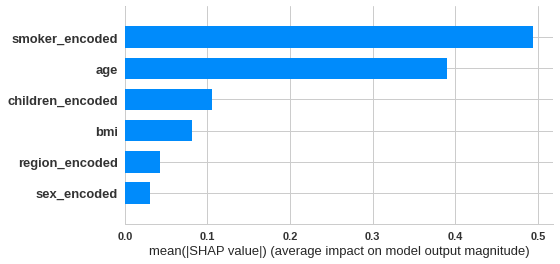

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

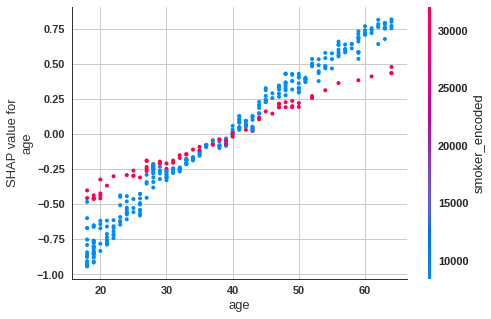

In [ ]:
shap.dependence_plot("age", shap_values, X_test)

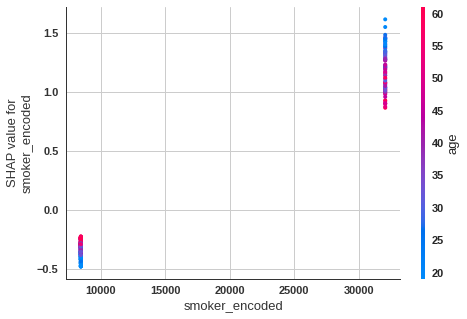

In [ ]:
shap.dependence_plot("smoker_encoded", shap_values, X_test)

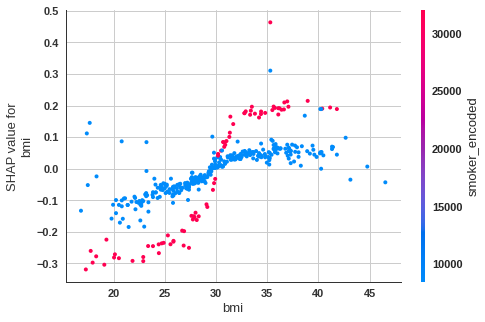

In [ ]:
shap.dependence_plot("bmi", shap_values, X_test)

## Save model as pkl


##Testing the Data

In [ ]:
## 